# Lab 3: Global Optimization with Gaussian Processes

## Gaussian Process Summer School 2020

The goal of this lab session is to illustrate the concepts seen during the tutorial in Gaussian processes for Global optimization. We will focus on two aspects of Bayesian Optimization (BO): (1) the choice of the model (2) the choice of the acquisition function.

The technical material associated to the methods used in this lab can be found in the slides of the tutorial. 

## 1. Getting started

In addition to GPy, this lab uses GPyOpt (http://sheffieldml.github.io/GPy/), a satellite module of GPy useful to solve global optimization problems. Please be sure that it is correctly installed before starting by following the Getting Started page.

Some of the options of GPyOpt depend on other external packages: DIRECT, cma, pyDOE. Please be sure that this are installed if you want to use all the options. With everything installed, you are ready to start. 

Now, just as in the previous lab, specify to include plots in the notebook and to import relevant libraries.

In [1]:
%pylab inline  
import GPy
import GPyOpt
import numpy as np
from numpy.random import seed
seed(12345)

Populating the interactive namespace from numpy and matplotlib


### Remembering the basics

Before starting with the lab, remember that (BO) is an heuristic for global optimization of black-box functions. Let $f: {\mathcal X} \to R$ be a 'well behaved' continuous function defined on a compact subset ${\mathcal X} \subseteq R^d$. Our goal is to solve the global optimization problem of finding
$$ x_{M} = \arg \min_{x \in {\mathcal X}} f(x). $$

We assume that $f$ is a *black-box* from which only perturbed evaluations of the type $y_i = f(x_i) + \epsilon_i$, with $\epsilon_i \sim\mathcal{N}(0,\sigma^2)$, are  available. The goal is to find $x_M$ by minimizing the number of evaluations of $f$. To do this, we need to determine two crucial bits:

1. A **Gaussian process** that will capture the our beliefs on $f$. 

2. An **acquisition function** that based on the model will be useful to determine where to collect new evaluations of f. 

Remember that every time a new data point is collected the model is updated and the acquisition function optimized again. 

### Running example

We start with a one-dimensional example. Consider here the Forrester function 

$$f(x) =(6x-2)^2 \sin(12x-4),$$ defined on the interval $[0, 1]$. 

The minimum of this function is located at $x_{min}=0.78$. We assume that the evaluations of $f$ to are perturbed by zero-mean Gaussian noise with standard deviation 0.25. The Forrester function is part of the benchmark of functions of GPyOpt. To create the true function, the perturbed version and the boundaries of the problem you need to run the following cell. 

In [2]:
f_true = GPyOpt.fmodels.experiments1d.forrester()             # true function object
f_sim = GPyOpt.fmodels.experiments1d.forrester(sd=.25)        # noisy version
bounds = f_true.bounds                                        # problem constrains (implemented by default)
f_objective = f_sim.f                                         # objective function   

To plot the true $f$, simply write:

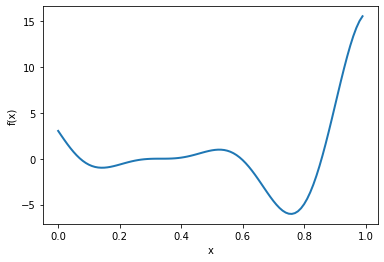

In [3]:
f_true.plot(bounds)

f_objective contains the function that we are going to optimize. You can define your own objective but it should be able to map any numpy array of dimension $n\times d$ (inputs) to a numpy array of dimension $n\times 1$ (outputs). For instance:

In [4]:
n = 8
x = np.random.rand(n).reshape(n,1)
x

array([[0.92961609],
       [0.31637555],
       [0.18391881],
       [0.20456028],
       [0.56772503],
       [0.5955447 ],
       [0.96451452],
       [0.6531771 ]])

In [5]:
f_objective(x)

array([[ 9.99379804],
       [ 0.30951655],
       [-0.53213703],
       [-0.92083089],
       [ 0.70757395],
       [ 0.04499155],
       [14.12247715],
       [-2.14113699]])

The bounds of the problem should be defined as a tuple containing the upper and lower limits of the box in which the optimization will be performed. In our example:

In [6]:
bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,1)}] 

To use BO to solve this problem, we need to create a GPyOpt object in which we need to specify the following elements: 
* The function to optimize.
* The box constrains of the problem.
* The model, that is fixed by default to be a GP with a SE kernel.
* The acquisition function (and its parameters).

We create an SE kernel as we do in GPy

In [7]:
k = GPy.kern.RBF(1)

And now we have all the elements to start optimizing $f$. We create the optimization problem instance. Note that you don't need to specify the evaluation budget of. This is because at this stage we are not running the optimization, we are just initializing the different elements of the BO algorithm. 

In [8]:
# Creation of the object that we will use to run BO.
seed(1234)
myBopt = GPyOpt.methods.BayesianOptimization(f = f_objective,        # function to optimize       
                                             domain = bounds,        # box-constrains of the problem
                                             kernel = k,             # kernel of the GP   
                                             acquisition_type='EI')       # acquisition = Expected improvement

In [9]:
?GPyOpt.methods.BayesianOptimization

At this point you can access to a number of elements in myBopt, including the GP model and the current dataset (initialized at 3 random locations by default).

In [10]:
myBopt.X

array([[0.19151945],
       [0.62210877],
       [0.43772774],
       [0.78535858],
       [0.77997581]])

In [11]:
myBopt.Y

array([[-0.95287634],
       [-1.19407487],
       [ 0.29000479],
       [-5.3506129 ],
       [-5.22815975]])

In [12]:
# Run the optimization (may take a few senconds)
max_iter = 15                       # evaluation budget
myBopt.run_optimization(max_iter)   # run optimization 

And that's it! You should have receive a message describing if the method converged (two equal x's are selected in consecutive steps of the optimization) or if the maximum number of iterations was reached. In one dimensional examples, you can visualize the model and the acquisition function (normalized between 0 and 1) as follows.

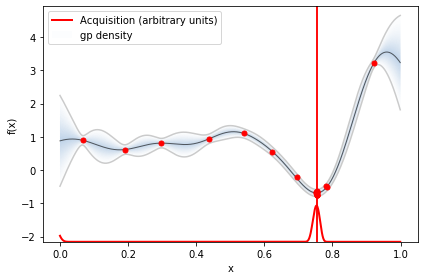

In [13]:
myBopt.plot_acquisition()

You can only make the previous plot if the dimension of the problem is 1 or 2. However, you can always how the optimization evolved by running:

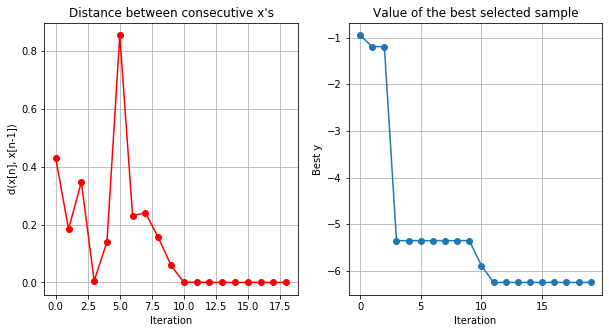

In [14]:
myBopt.plot_convergence()

The first plot shows the distance between the last two collected observations at each iteration. This plot is useful to evaluate the convergence of the method. The second plot shows the best found value at each iteration. It is useful to compare different methods. The fastest the curve decreases the better the method. 

Noise variance of the GP is automatically bounded to avoid numerical problems. In case of having a problem where the evaluations of $f$ are exact you only need to include 'exact_feval=True' when creating the BO object as above. Now, to run the optimization for certain number of iterations you only need to write:

In [15]:
myBopt.model.model

GP_regression.,value,constraints,priors
rbf.variance,2.2938619468750314,+ve,
rbf.lengthscale,0.11088633298610727,+ve,
Gaussian_noise.variance,0.0026639982475618737,"1e-09,1000000.0",


### Exercise 1

Use Bayesian optimization to find the minimum of the function $f(x)= x^2 + 10 \sin(x)$ in the interval [-10, 10]. 

(a) Define the bounds of the problem, the function and check that it admits a numpy array of observations as input.

In [16]:
def g(x):
    return x**2 + 10*np.sin(x)

bounds_g = [{'name': 'var_1', 'type': 'continuous', 'domain': (-10,10)}] 

x = np.random.rand(n).reshape(n,1)
g(x)

array([[8.56492259],
       [3.15258865],
       [5.64364388],
       [6.70667823],
       [4.78655946],
       [5.46222156],
       [8.2777045 ],
       [2.81455086]])

(b) Create a GPyOpt object for global optimization using a Mattern52 kernel and adding a gitter of $0.1$ to the expected improvement acquisition (Hint: when creating the object use the option acquisition_par = 0.1). 

In [17]:
k_g = GPy.kern.Matern52(1)

BO_g = GPyOpt.methods.BayesianOptimization(f = g,           
                                           domain = bounds_g,       
                                           kernel = k_g,          
                                           acquisition='EI',
                                           acquisition_par = 0.1)

(c) For stability reasons, constrain the noise of the model to be 10e-4. 

In [18]:
BO_g.model.noise_var = 0.0001

(d) Run the optimization for 10 iterations. Make and comment the convergence plots. Has the method converged? 

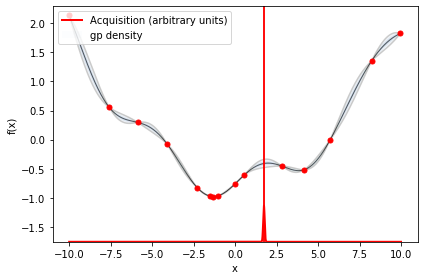

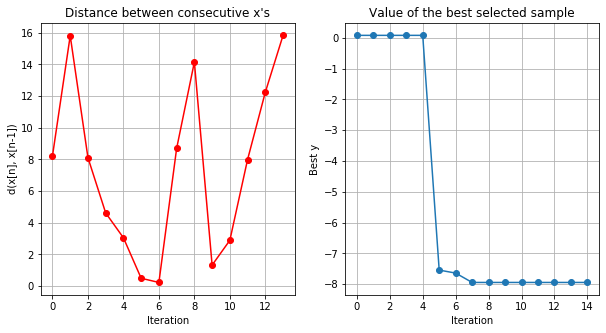

In [19]:
BO_g.run_optimization(10)
BO_g.plot_acquisition()
BO_g.plot_convergence()

## 2. Acquisition functions

In this section we are going to have a look to different acquisition functions. In GPyOpt you can use the expected improvement ('EI') the maximum probability of improvement ('MPI') and the lower confidence bound. When using GPyOpt you can simply specify the acquisition that you want at the moment of creating the BO object. However, you can also load these acquisitions as separate objects.

In [20]:
from GPyOpt.acquisitions import AcquisitionEI, AcquisitionLCB, AcquisitionMPI 

To access these acquisitions 'externally' we create a GP model using the objective function in Section 1 evaluated in 10 locations.

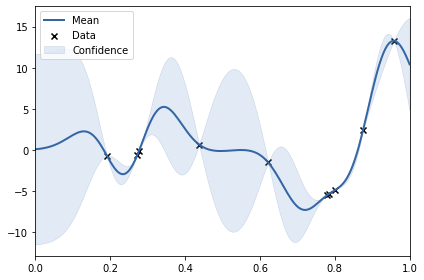

In [21]:
seed(1234)
n = 10
X = np.random.rand(n).reshape(n,1)
Y = f_objective(X)
m = GPy.models.GPRegression(X,Y)
m.optimize()
m.plot([0,1])

## Now we pass this model into a GPyOpt Gaussian process model

from GPyOpt.models import GPModel
model = GPModel(optimize_restarts=5,verbose=False)
model.model = m

We define the bounds of the input space to be between zero and one.

In [22]:
from GPyOpt import Design_space  ## GPyOpt design space

space = Design_space([{'name': 'var_1', 'type': 'continuous', 'domain': (0,1)}] )

Now, let's have a look to see what do we need to create an acquisition, for instance the Expected improvement and the Lower Confidence Bound.

In [23]:
AcquisitionEI?

In [24]:
AcquisitionLCB?

Now we create thee objects, one for each acquisition. The gitter parameter, to balance exploration and exploitation, need to be specified.

In [25]:
acq_EI = AcquisitionEI(model,space, jitter = 0)
acq_LCB = AcquisitionLCB(model,space,exploration_weight = 2)
acq_MPI = AcquisitionMPI(model,space,jitter = 0)

The objects acq_EI, acq_LCB, acq_MPI contain the acquisition functions and their gradients. By running the following piece of code you can visualize the three acquisitions. Note that we add a negative sign before each acquisition. This is because within GPyOpt these functions are minimized (instead of maximized) using gradient optimizers (like BFGS) to select new locations. In this plot, however, the larger is the value of the acquisition, the better is the point. 

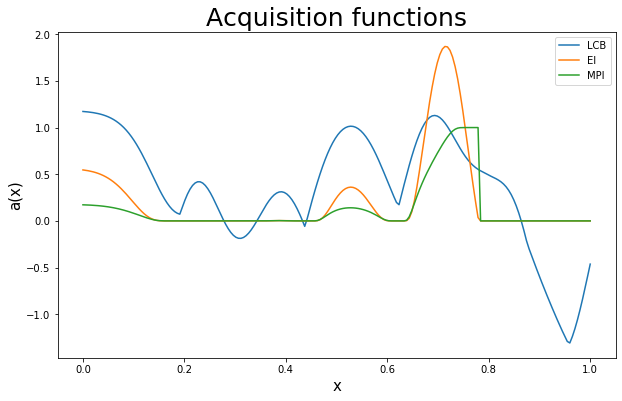

In [26]:
# Plot the three acquisition functions (factor 0.1 added in in the LCB for visualization)
X_grid = np.linspace(0,1,200)[:, None]
plt.figure(figsize=(10,6))
plt.title('Acquisition functions',size=25)
plt.plot(X_grid, - 0.1*acq_LCB.acquisition_function(X_grid),label='LCB')
plt.plot(X_grid, -acq_EI.acquisition_function(X_grid),label='EI')
plt.plot(X_grid, -acq_MPI.acquisition_function(X_grid),label='MPI')
plt.xlabel('x',size=15)
plt.ylabel('a(x)',size=15)
legend();

### Exercise 2

(a) According to the previous plot, what areas in the domain are worth exoloring and why? How can we interpret the previous plot in terms of the exploration/exploitation trade off of each one of the three acquisitions?

(b) Now make a plot comparing the shape of the LCB acquisition (of GP-UCB in the literature) with values different values of parameters. Use the values $[0,0.1,0.25,0.5,1,2,5]$. How does the decision about where to collect the sample change when we increase the value of the parameter?

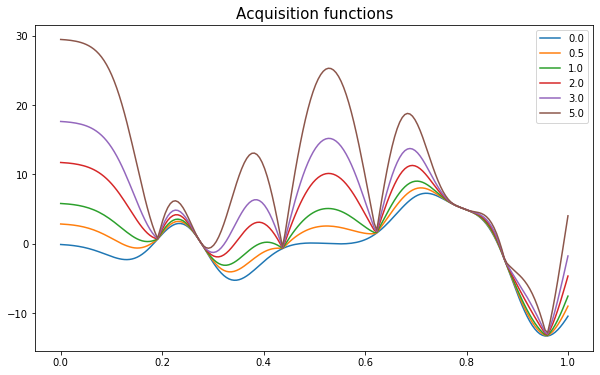

In [27]:
acq_LCB = AcquisitionLCB(model,space,exploration_weight = 0)
grid_par = np.array([0,0.5,1,2,3,5])

plt.figure(figsize=(10,6))
plt.title('Acquisition functions',size=15)
for param in grid_par:
    acq_LCB = AcquisitionLCB(model,space,exploration_weight = param)
    plt.plot(X_grid, -acq_LCB.acquisition_function(X_grid),label=str(param))
legend()

### Exercise 3

Consider the sixhumpcamel function defined as
$$f(x_1,x_2) = \left(4-2.1x_1^2 + \frac{x_1^4}{3} \right)x_1^2 + x_1x_2 + (-4 +4x_2^2)x_2^2,$$

in $[-2,2]\times [-1,1]$. This function has two global minima, at $(0.0898,-0.7126)$ and $(-0.0898,0.7126)$. This function is also implemented in GPyOpt so, to load and visualize it simply run.

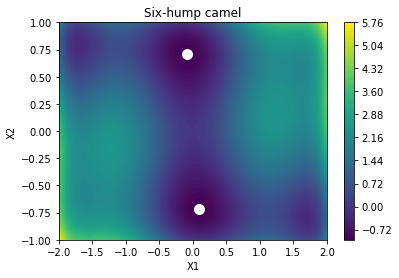

In [28]:
GPyOpt.fmodels.experiments2d.sixhumpcamel().plot()
f_shc = GPyOpt.fmodels.experiments2d.sixhumpcamel(sd = 0.1).f  # simulated version with some noise

(a) Create three objects to optimize this function using the the 'EI' (with parameter equal to zero), the LCB (with parameter equal to 2) and the MPI (with parameter equal to zero). Use the same initial data in the three cases (Hint: use the options 'X' and 'Y' when creating the BO object).

In [29]:
from GPyOpt import Design_space  ## GPyOpt design space

bounds_shc = GPyOpt.fmodels.experiments2d.sixhumpcamel().bounds
variables = [{'name': 'var_1', 'type': 'continuous', 'domain': bounds_shc[0]},
            {'name': 'var_2', 'type': 'continuous', 'domain': bounds_shc[1]}]

space = GPyOpt.Design_space(variables)


from GPyOpt.experiment_design.random_design import RandomDesign
seed(12345)
n_data = 3
sampler = RandomDesign(space)
X = sampler.get_samples(n_data)
Y = f_shc(X)

BO_EI  = GPyOpt.methods.BayesianOptimization(f_shc,variables,X=X,Y=Y,acquisition='EI',jitter=0)
BO_LCB = GPyOpt.methods.BayesianOptimization(f_shc,variables,X=X,Y=Y,acquisition='LCB',acquisition_weight=2)
BO_MPI = GPyOpt.methods.BayesianOptimization(f_shc,variables,X=X,Y=Y,acquisition='MPI',jitter=0)

(b) In the three cases run the optimization for 30 iterations

In [ ]:
max_iter = 30
BO_EI.run_optimization(max_iter)
BO_LCB.run_optimization(max_iter)
BO_MPI.run_optimization(max_iter)

(c) Now make a plot comparing the three methods. The x axis should contain the number of iterations and y axis the best found value (Hint: use .Y_best to extract from the BO objects the best current value at each iteration). Which acquisition is has the best performance in this example?

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Comparison of acquisition functions',size=15)
plt.plot(BO_EI.Y_best,label = 'EI')
plt.plot(BO_LCB.Y_best,label = 'LCB')
plt.plot(BO_MPI.Y_best,label = 'MPI')
legend();

(d) Compare the models and the acquisition functions in the three cases (after the 30 iterations). What do you observe? 

In [ ]:
BO_EI.plot_acquisition()
BO_LCB.plot_acquisition()
BO_MPI.plot_acquisition()

display(BO_EI.model.model)
display(BO_LCB.model.model)
display(BO_MPI.model.model)

---
### Credit

This notebook was written by Javier Gonzalez.